In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression

from fairfl.metrics.cross_validation import cross_validation
from fairfl.utils.read_data import DatasetUtils

In [3]:
utils = DatasetUtils()

In [4]:
df = utils.get_acs_income_data_procesed()
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,ST,PINCP
0,18.0,1.0,"Some college, but less than 1 year",Never married or under 15 years old,4720.0,13.0,17.0,21.0,Female,others,1.0,0
1,53.0,5.0,GED or alternative credential,Never married or under 15 years old,3605.0,18.0,16.0,40.0,Male,White alone,1.0,0
2,41.0,1.0,Regular high school diploma,Never married or under 15 years old,7330.0,1.0,17.0,40.0,Male,White alone,1.0,0
3,18.0,6.0,"Some college, but less than 1 year",Never married or under 15 years old,2722.0,1.0,17.0,2.0,Female,White alone,1.0,0
4,21.0,5.0,"1 or more years of college credit, no degree",Never married or under 15 years old,3870.0,12.0,17.0,50.0,Male,White alone,1.0,0


In [5]:
df.groupby("RAC1P").size()

RAC1P
White alone    1298126
others          366374
dtype: int64

In [6]:
# tüm veri setine uygulacağımız için State bilgisine ihtiyacımız yok
df = df.drop("ST", axis=1)

# Basic Pipeline Steps
- kategorik özellikler yapılacak işlemler
    - COW --> OneHotEncoder
    - SCHL --> burada sıralı bir ilişki var gibi OrdinalEncoder uygulayabiliriz
    - MAR --> OneHotEncoder
    - OCCP --> OneHotEncoder
    - POBP --> OneHotEncoder
    - RELP --> OneHotEncoder
    - SEX --> OneHotEncoder
    - RAC1P -->  OneHotEncoder

- numerik veri alanlarına yapılacak işlemler
    - AGEP --> yaş veri alanı bu veri alınında bining yapılacak değerleri veri analizinden incelediğimiz 17 yaş ile 96 yaş arasında ortalama 43 --> [0,25,45,65,100] --> ["Young", "Middle", "Senior", "Old"]
          # sonrasında OrdinalEncoder uygulanabilir
    - WKHP --> çalışma saatine de benzer bir yöntem uygulabilir binning + OrdinalEncoder --> 1 ile 99 arasında değerler ortalama 38 --> [0,25,40,60,100] --> ["Part-time", "Full-time", "Over-time", "Workaholic"]

# Feature Engineering

In [7]:
df.groupby("SCHL").size()

SCHL
1 or more years of college credit, no degree      255517
Associate's degree                                154281
Bachelor's degree                                 366380
Doctorate degree                                   27530
GED or alternative credential                      55883
Master's degree                                   160594
Professional degree beyond a bachelor's degree     41426
Regular high school diploma                       344823
Some college, but less than 1 year                121246
below high-school                                 136820
dtype: int64

In [8]:
schl_order = ["below high-school", "Regular high school diploma", "GED or alternative credential",
              "Some college, but less than 1 year", "1 or more years of college credit, no degree",
              "Associate's degree", "Bachelor's degree", "Master's degree",
              "Professional degree beyond a bachelor's degree", "Doctorate degree"]

In [9]:
enc = OrdinalEncoder(categories=[schl_order])

In [10]:
df["SCHL"] = enc.fit_transform(df[["SCHL"]])

In [11]:
# yaş veri alanı
df["AGEP"] = pd.cut(df["AGEP"], bins=[0, 25, 45, 65, 100], labels=["Young", "Middle", "Senior", "Old"], ordered=True)
df.groupby("AGEP").size()

AGEP
Young     254579
Middle    642177
Senior    649274
Old       118470
dtype: int64

In [12]:
enc_age = OrdinalEncoder(categories=[["Young", "Middle", "Senior", "Old"]])
df["AGEP"] = enc_age.fit_transform(df[["AGEP"]])
df.groupby("AGEP").size()

AGEP
0.0    254579
1.0    642177
2.0    649274
3.0    118470
dtype: int64

In [13]:
# çalışma zamanı
df["WKHP"] = pd.cut(df["WKHP"], bins=[0, 25, 40, 60, 100], labels=["Part-time", "Full-time", "Over-time", "Workaholic"],
                    ordered=True)
enc_hpw = OrdinalEncoder(categories=[["Part-time", "Full-time", "Over-time", "Workaholic"]])
df["WKHP"] = enc_hpw.fit_transform(df[["WKHP"]])
df.groupby("WKHP").size()

WKHP
0.0    281492
1.0    942260
2.0    398052
3.0     42696
dtype: int64

In [14]:
# diğer sütunlara one-hot uygulayalım
df_encoded = pd.get_dummies(df, columns=['COW', 'MAR', 'OCCP', 'RELP', 'RAC1P', 'SEX'])

In [15]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664500 entries, 0 to 1664499
Columns: 569 entries, AGEP to SEX_Male
dtypes: float64(4), int64(1), uint8(564)
memory usage: 958.8 MB


In [16]:
x = df_encoded.drop('PINCP', axis=1)
y = df_encoded['PINCP']

## ML Model

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

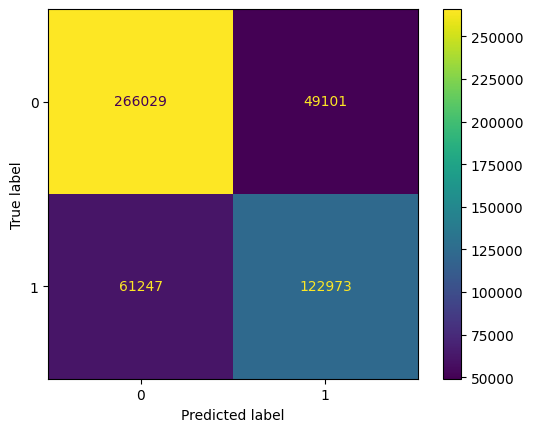

In [19]:
cm = confusion_matrix(Y_test, model.predict(X_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()


In [20]:
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83    315130
           1       0.71      0.67      0.69    184220

    accuracy                           0.78    499350
   macro avg       0.76      0.76      0.76    499350
weighted avg       0.78      0.78      0.78    499350



## K-Fold

In [21]:
print(cross_validation(model=model, x=x, y=y, cv=5))

                                  0         1         2         3         4
Training Accuracy scores   0.781025  0.780420  0.780736  0.776383  0.787670
Training Precision scores  0.719639  0.722612  0.725324  0.719499  0.730860
Training Recall scores     0.665849  0.657006  0.652915  0.645521  0.671870
Training F1 scores         0.691700  0.688249  0.687217  0.680505  0.700125
Test Accuracy scores       0.780925  0.780475  0.781922  0.777068  0.786603
Test Precision scores      0.719952  0.722804  0.725793  0.721203  0.729336
Test Recall scores         0.664742  0.656852  0.657145  0.645097  0.670331
Test F1 scores             0.691247  0.688252  0.689765  0.681030  0.698590
